In [1]:
import Heston
import BlackScholes
import pandas as pd
import numpy as np
import copy

import QuantLib as ql
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.optimize import least_squares
import scipy.integrate
import time

In [28]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

r = 0.0291
q = 0.0154
K = moneyness*S0/100

<IPython.core.display.Javascript object>


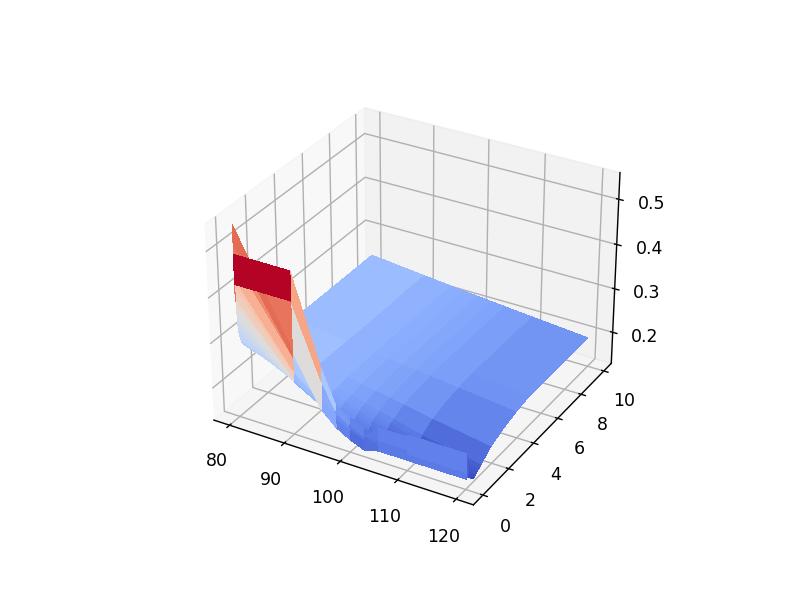

In [3]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)
surf = ax.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [16]:
P = copy.copy(IV)

for j in range(len(maturities)):
    for i in range(len(moneyness)):
        P[j,i] = BlackScholes.BSCall(S0, K[i], maturities[j], r, q, IV[j,i])

L = 12
N = 64
options_type = np.ones(9)

In [16]:
start_time = time.time()

params = np.array([.2, .5, .2, .3, -.8])

def f(prms):
    sigma_0, kappa,eta, theta, rho = prms
    precomp, a, b = Heston.precomputed_terms(r, q, T, sigma_0, kappa, eta, theta, rho, L, N)
    P_cal = Heston.cos_method_Heston_LF(precomp, a, b, T, r, q, sigma_0, kappa, eta, theta, \
                                        rho, S0, K, N, options_type, L)  
    err = P_cal - P
    return err

def j(prms):
    sigma_0, kappa,eta, theta, rho = prms
    return Heston.grad_c(T, K, sigma_0, kappa, eta, theta, rho, S0, r, q, 60, -1, 100)

bnds = ([1e-10,1e-10,1e-10,1e-10,-1.], [np.inf,np.inf,np.inf,np.inf,0.])
min_ = least_squares(f, x0 = params, bounds = bnds, verbose = 1, max_nfev = 50)
print(f'Time to run: {time.time() - start_time: .0f} s')

sigma_0, kappa, eta, theta, rho = min_.x
print(f'Calibrated parameters:\tkappa:{ kappa: .3f}\tsigma_0:{ sigma_0: .3f}\teta:{ eta: .3f}\ttheta:{ theta: .3f}\trho: {rho:.3f}')
P_cal = Heston.analytic_hest(S0, K, T, r, q, kappa, theta, rho, eta, sigma_0, options_type)
IV_cal = BlackScholes.BSImpliedVol(S0, K, T, r, q, P_cal, Option_type = 1, toll = 1e-5)

print(f'Feller condition: {2*kappa*eta - theta**2}')

The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 1.2184e+04, final cost 3.8407e-01, first-order optimality 3.73e-01.
Time to run:  1 s
Calibrated parameters:	kappa: 4.805	sigma_0: 0.000	eta: 0.436	theta: 1.362	rho: -0.565
Feller condition: 2.340130288465361


<IPython.core.display.Javascript object>


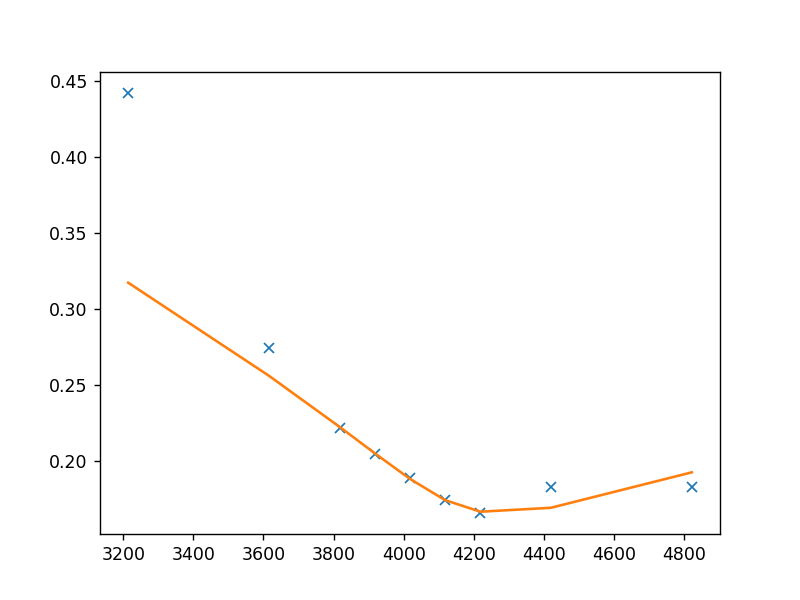

err = 0.40305248460306725	 err_IV = 0.05470517001366018


In [17]:
%matplotlib notebook

plt.plot(K,IV[9,:], 'x')
plt.plot(K,IV_cal)
plt.show()

err = np.linalg.norm((P-P_cal)/P, 1)/len(K)
err_IV = np.linalg.norm((IV[9,:]-IV_cal)/IV[9,:], 1)/len(K)
print(f'err = {err}\t err_IV = {err_IV}')

<IPython.core.display.Javascript object>


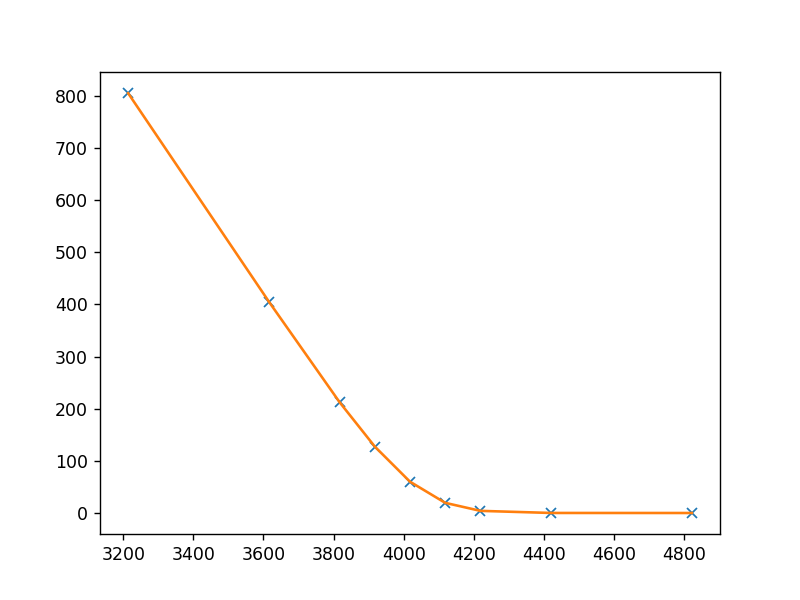

In [18]:
%matplotlib notebook

plt.plot(K,P, 'x')
plt.plot(K,P_cal)
plt.show()